<a href="https://colab.research.google.com/github/KeaganChasenski/Hand-Written-Digit-Prediction-/blob/main/DSP_Projecty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision

from torchvision import datasets, transforms
from torch import nn, optim

import matplotlib.pyplot as plt
from time import time 

from PIL import Image

# Hyper Parameters
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.9 
epochs = 30

In [2]:
def load_data():
    print("loading data...")
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,)),])

    trainset = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

    testset = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True)

    # creating a iterator
    dataiter = iter(trainloader) 
    # creating images for image and lables for image number (0 to 9) 
    images, labels = dataiter.next() 

    # Return images and labels created from the data iterator
    return images, labels, trainloader, testloader

In [3]:
def build_Model():

    print("building model... \n")
    # Firstly we know that the first input layer with need 784 neurons ( 28 pixels X 28 pixels)
    # nn.Sequetial from PyTorch allows a tensor to passed sequentially through operations

    model=nn.Sequential(nn.Linear(784,256), # 1st layer: 784 input 128 output
            nn.ReLU(),          # ReLu activation for 1st layer
            nn.Linear(256,128),  # 2nd Layer: 128 Input and 64 output
            nn.ReLU(),          # ReLu activation for 2nd layer
            nn.Linear(128,10),   # 3rd Layer: 64 Input and 10 outout for (0-9)
            nn.LogSoftmax(dim=1) # log softmax for the probablities of the output layer (3rd)
            ) 

    # Display model used
    print("Model built: ")
    print("\t 1) 1st layer: Linear (in_ features = 784, out_features = 128)")
    print("\t \t Activation function for 1st layer = ReLU()")
    print("\t 2) 2nd layer: Linear (in_ features = 128, out_features = 64)")
    print("\t \t Activation function for 2nd layer = ReLU()")
    print("\t 3) 3rd layer: Linear (in_ features = 64, out_features = 10)")
    print("\t \t Activation function for 3rd layer = LogSoftmax() \n")

    # Return model
    return model


In [4]:
def loss_function(images, labels, train_loader, model):
    print("defining loss function...")

    # Define cross Entropy Loss
    loss_function = nn.CrossEntropyLoss()
    # Get next image and label from the traini_loader using the iterator 
    images, labels = next(iter(train_loader))
    # Flatten to shape we can perform calculations on
    images = images.view(images.shape[0], -1)

    #log probabilities
    logps = model(images) 
    #calculate the loss
    loss = loss_function(logps, labels) 
    
    # Return loss calculation and the cross entropy function
    return loss, loss_function


In [5]:
def grad_weights(loss, model):

    # to calculate gradients of parameters 
    # Use backward pass from PyTorch
    loss.backward()

In [6]:
def train(model, train_loader, loss_function):
    print("Training neural network...")

    # Optimiser using stochastic gradient descent
    optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Load images and labels through iterator
    images, labels = next(iter(train_loader))
    images.resize_(64, 784)

    # Clear gradients
    optimiser.zero_grad()

    # Forward pass
    output = model(images)
    loss = loss_function(output, labels)

    # backward pass to update weights
    loss.backward()

    # Get start time
    time0 = time()
 

    # Loop for each training epoch
    for e in range(epochs):
        loss_total = 0

        # Loop for each image and assoicated label in the train_loader
        for images, labels in train_loader:
            # Flatenning MNIST images with size [64,784]
            images = images.view(images.shape[0], -1) 
        
            # Set gradient = 0 for each epoch
            optimiser.zero_grad()
            
            # Model for each image
            output = model(images)
            
            # calculate loss
            loss = loss_function(output, labels)
            
            # Learn from backpropagating
            loss.backward()
            
            # Optimizes weights 
            optimiser.step()
            
            # calculate the running loss total
            loss_total += loss.item()

        # Display for each epoch the running loss
        print("Epoch {} -> Training loss = {}".format(e, (loss_total/len(train_loader))))

    # Display total runnning time of training.
    print("\nTraining Time (in minutes) =",(time()-time0)/60)

In [7]:
def validate(test_loader, model):
    print("")
    print("Validating model...")

    # Initiates counters
    correct_counter = 0
    total_counter = 0

    # for each image bacth in the testing_loader
    for images,labels in test_loader:
        # Loop through the image batch
        for i in range(len(labels)):
            # load the image at i counter
            img = images[i].view(1, 784)

            # Calculate the log probability using no gradient 
            # Speed up the process using no gradient
            with torch.no_grad():

                # Call image and pass in image
                logps = model(img)

            # Convert to natural number by taking exponent of log
            ps = torch.exp(logps)
            # Creates an array of size 10, for probability of each digit
            probab = list(ps.numpy()[0])

            # Get the max, which will be the classification
            pred_label = probab.index(max(probab))
            # Get ground truth for current image
            true_label = labels.numpy()[i]

            # Compare ground truth and prediction
            if(true_label == pred_label):
                # If = then prediciton was correct
                # Add 1 to counter
                correct_counter += 1
            # Increase total counter
            total_counter += 1

    # Display the accuracy of as correct_counter / totoal_counter
    print("Number Of Images Tested =", total_counter)
    print("Model Accuracy =", (correct_counter/total_counter))

In [8]:
def classify_image(path, model, ):

    # Open Image using PIL Image
    img = Image.open(path)

    # Create a transform for the image
    # Convert it to a tensor
    t = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1)
    ])
     
    # Transform the image
    img_tr = t(img)
    # Flatten to 1D by 784 pixels
    img_tr_new = img_tr.view(1, 784)
    
    plt.imshow(img, cmap='gray_r');

    # Allow use of tensor using no gradient to speed up process
    with torch.no_grad():
        # log probability from model of the image
        logpb = model(img_tr_new)
    
    # convert log probability to exponetial to get acutal value
    pb = torch.exp(logpb)
    # Will return an array of probabilites for each digit
    probab = list(pb.numpy()[0])

    return probab

In [9]:
# Function calls

# Load and transform the MNIST data set
images, labels, train_loader, test_loader = load_data()
# Build the model
model = build_Model()
# Create the loss function
loss, loss_function = loss_function(images,labels, train_loader, model)
# Function to calculate the gradient of descent and weights
grad_weights(loss, model)

# Train the model
train(model, train_loader, loss_function)

#Validate the model
validate(test_loader, model)



loading data...
building model... 

Model built: 
	 1) 1st layer: Linear (in_ features = 784, out_features = 128)
	 	 Activation function for 1st layer = ReLU()
	 2) 2nd layer: Linear (in_ features = 128, out_features = 64)
	 	 Activation function for 2nd layer = ReLU()
	 3) 3rd layer: Linear (in_ features = 64, out_features = 10)
	 	 Activation function for 3rd layer = LogSoftmax() 

defining loss function...
Training neural network...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch 0 -> Training loss = 0.3076688815166415
Epoch 1 -> Training loss = 0.1034963679885162
Epoch 2 -> Training loss = 0.06730567892221039
Epoch 3 -> Training loss = 0.04874701128785076
Epoch 4 -> Training loss = 0.035006257245810565
Epoch 5 -> Training loss = 0.027012230864210205
Epoch 6 -> Training loss = 0.019589222667433237
Epoch 7 -> Training loss = 0.014289511216016038
Epoch 8 -> Training loss = 0.009419546798670238
Epoch 9 -> Training loss = 0.00635480594989971
Epoch 10 -> Training loss = 0.0051852714294558675
Epoch 11 -> Training loss = 0.0028738472737459544
Epoch 12 -> Training loss = 0.0016595835239830753
Epoch 13 -> Training loss = 0.001084862771744726
Epoch 14 -> Training loss = 0.0009601275226085486
Epoch 15 -> Training loss = 0.0007059259361475208
Epoch 16 -> Training loss = 0.0006004877079970517
Epoch 17 -> Training loss = 0.0005362659363970313
Epoch 18 -> Training loss = 0.000473842693755907
Epoch 19 -> Training loss = 0.00043514985831423275
Epoch 20 -> Training loss = 

Done! 

Please enter a filepath:
/content/Thick/level08thick.jpg
Classifier = 0
Please enter a filepath:
/content/Thick/lev28thick.jpg
Classifier = 0
Please enter a filepath:
/content/Thick/lev36thick.jpg
Classifier = 6
Please enter a filepath:
/content/Thick/lev26thick.jpg
Classifier = 7
Please enter a filepath:
/content/Thick/lev27thick.jpg
Classifier = 3
Please enter a filepath:
exit
exiting...


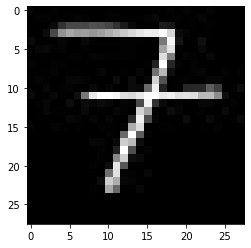

In [11]:
print("Done! \n")

# Blank path for first condition of while loop
path = ""

while True:
    # Get the image at the file path entered
    print("Please enter a filepath:")
    path = input()
    
    if path == 'exit':
      break
      
    # Call the classifciation function
    probab = classify_image(path, model)
    
    # The classification of the digit is the max probabilty from out model
    print("Classifier =", probab.index(max(probab)))

    # Show the image
    img = Image.open(path)
    plt.imshow(img, cmap='gray_r');

print("exiting...")

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
torch.save(model, 'checkpoint.pth')
# download checkpoint file

img = Image.open('/content/Testing_Own/img2.jpg')

# Create a transform for the image
# Convert it to a tensor
t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])
  
# Transform the image
img_tr = t(img)
# Flatten to 1D by 784 pixels
img_tr_new = img_tr.view(1, 784)

plt.imshow(img, cmap='gray_r');